In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
from matplotlib import gridspec

import uproot3 as uproot

# Plots setting
plt.rcParams['axes.labelsize'] = 13
tick_size = 13
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.title_fontsize'] = 13
legend_size = 12

In [2]:
from scipy.stats import norm, chisquare 
from scipy.optimize import curve_fit, leastsq
from scipy.special import logit

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost as xgb
from xgboost import XGBClassifier

### Import functions.py

In [3]:
# FUNCTIONS FOR EVENT SELECTION
# ----------------------------------------------------------------- EVENT SELECTION
def is_truth_nueCC(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1))]
    return df_

def is_truth_nueCC_inside(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_nueCC_outside(df):
    df_ = df[((abs(df.truth_nuPdg) == 12) & (df.truth_isCC == 1) & (df.truth_vtxInside == 0))]
    return df_

def is_truth_numuCC(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1))]
    return df_

def is_truth_numuCC_inside(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_numuCC_outside(df):
    df_ = df[((abs(df.truth_nuPdg) == 14) & (df.truth_isCC == 1) & (df.truth_vtxInside == 0))]
    return df_

def is_truth_NC(df):
    df_ = df[(df.truth_isCC == 0)]
    return df_

def is_truth_NC_inside(df):
    df_ = df[((df.truth_isCC == 0) & (df.truth_vtxInside == 1))]
    return df_

def is_truth_NC_outside(df):
    df_ = df[((df.truth_isCC == 0) & (df.truth_vtxInside == 0))]
    return df_

def is_FC(df):
    df_ = df[df.match_isFC == 1]
    return df_

def is_PC(df):
    df_ = df[df.match_isFC == 0]
    return df_

em_charge_scale = 0.95

def is_pi0(df, family='MC'):
    if family == 'DATA': df.loc[:,'kine_pio_mass'] = df.kine_pio_mass * em_charge_scale
    elif family == 'MC': pass
    else: print(' -------- WARNING: Wrong family')
        
    df_ = df[((df.kine_pio_flag == 1) & (df.kine_pio_vtx_dis < 9) | (df.kine_pio_flag == 2)) &
             (df.kine_pio_energy_1 > 40) & 
             (df.kine_pio_energy_2 > 25) & 
             (df.kine_pio_dis_1 < 110) & 
             (df.kine_pio_dis_2 < 120) & 
             (df.kine_pio_angle > 0) & 
             (df.kine_pio_angle < 174) & 
             (df.kine_pio_mass > 22) & 
             (df.kine_pio_mass < 300)]
    return df_

def is_NC(df):
    df_ = df[((df.cosmict_flag == 0) & (df.numu_score < 0))]
    return df_

def is_numuCC(df):
    df_ = df[((df.numu_cc_flag >= 0) & (df.numu_score > 0.9))]
    return df_

def is_nueCC(df):
    df_ = df[((df.numu_cc_flag >= 0) & (df.nue_score > 7))]
    return df_

def is_generic(df):
    df_ = df[(df.match_found == 1) & 
             (df.stm_eventtype != 0) &
             (df.stm_lowenergy == 0) &
             (df.stm_LM == 0) &
             (df.stm_TGM == 0) &
             (df.stm_STM == 0) &
             (df.stm_FullDead == 0) &
             (df.stm_clusterlength > 15)]
    return df_

def is_not_generic(df):
    df_ = df[~((df.match_found == 1) & 
               (df.stm_eventtype != 0) &
               (df.stm_lowenergy == 0) &
               (df.stm_LM == 0) &
               (df.stm_TGM == 0) &
               (df.stm_STM == 0) &
               (df.stm_FullDead == 0) &
               (df.stm_clusterlength > 15))]
    return df_

def is_preselection(df):
    df_ = df[(df.match_found == 1) & 
             (df.stm_eventtype != 0) &
             (df.stm_lowenergy == 0) &
             (df.stm_LM == 0) &
             (df.stm_TGM == 0) &
             (df.stm_STM == 0) &
             (df.stm_FullDead == 0) &
             (df.stm_clusterlength > 0)]
    return df_

def Cosmic(df):
    # Badreco match or events with no true energy inside
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def not_Cosmic(df):
    # Opposite of Cosmic
    df_ = df[~((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def Active(df):
    # Active volume (truth)
    df_ = df[(df.truth_vtxX > -1) &
             (df.truth_vtxX <= 254.3) &
             (df.truth_vtxY > -115.0) &
             (df.truth_vtxY <= 117.0) &
             (df.truth_vtxZ > 0.6) &
             (df.truth_vtxZ <= 1036.4)]
    return df_


# FUNCTIONS FOR EVENT PRE-PROCESSING
# --------------------------------------------------------------------------------------- PRE-PROCESSING
def gen_run_subrun_list(input_file, name_list):
    # Get useful variables
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(['run', 'subrun'], flatten=False)
    df_eval.drop_duplicates(inplace=True) 
    np.savetxt(name_list, df_eval.values, fmt='%d')

BDT_variab_all = ['cosmic_n_solid_tracks', 'cosmic_energy_main_showers',
                  'cosmic_energy_direct_showers', 'cosmic_energy_indirect_showers',
                  'cosmic_n_direct_showers', 'cosmic_n_indirect_showers',
                  'cosmic_n_main_showers', 
                  # -----------------------------------------------
                  'gap_flag_prolong_u', 'gap_flag_prolong_v',
                  'gap_flag_prolong_w', 'gap_flag_parallel',
                  'gap_n_points', 'gap_n_bad',
                  'gap_energy', 'gap_num_valid_tracks',
                  'gap_flag_single_shower', 
                  # -----------------------------------------------
                  'mip_quality_energy', 'mip_quality_overlap',
                  'mip_quality_n_showers', 'mip_quality_n_tracks', 
                  'mip_quality_flag_inside_pi0', 'mip_quality_n_pi0_showers', 
                  'mip_quality_shortest_length', 'mip_quality_acc_length',
                  'mip_quality_shortest_angle', 'mip_quality_flag_proton',
                  # -----------------------------------------------
                  'mip_energy',
                  'mip_n_end_reduction', 'mip_n_first_mip',
                  'mip_n_first_non_mip', 'mip_n_first_non_mip_1',
                  'mip_n_first_non_mip_2', 'mip_vec_dQ_dx_0',
                  'mip_vec_dQ_dx_1', 'mip_vec_dQ_dx_2',
                  'mip_vec_dQ_dx_3', 'mip_vec_dQ_dx_4',
                  'mip_vec_dQ_dx_5', 'mip_vec_dQ_dx_6',
                  'mip_vec_dQ_dx_7', 'mip_vec_dQ_dx_8',
                  'mip_vec_dQ_dx_9', 'mip_vec_dQ_dx_10',
                  'mip_vec_dQ_dx_11', 'mip_vec_dQ_dx_12',
                  'mip_vec_dQ_dx_13', 'mip_vec_dQ_dx_14',
                  'mip_vec_dQ_dx_15', 'mip_vec_dQ_dx_16',
                  'mip_vec_dQ_dx_17', 'mip_vec_dQ_dx_18',
                  'mip_vec_dQ_dx_19', 'mip_max_dQ_dx_sample',
                  'mip_n_below_threshold', 'mip_n_below_zero',
                  'mip_n_lowest', 'mip_n_highest',
                  'mip_lowest_dQ_dx', 'mip_highest_dQ_dx',
                  'mip_medium_dQ_dx', 'mip_stem_length',
                  'mip_length_main', 'mip_length_total',
                  'mip_angle_beam', 'mip_iso_angle',
                  'mip_n_vertex', 'mip_n_good_tracks',
                  'mip_E_indirect_max_energy', 'mip_flag_all_above',
                  'mip_min_dQ_dx_5', 'mip_n_other_vertex',
                  'mip_n_stem_size', 'mip_flag_stem_trajectory',
                  'mip_min_dis', 
                  # -----------------------------------------------
                  'pio_mip_id', 'pio_flag_pio', 
                  # -----------------------------------------------
                  'pio_1_mass', 'pio_1_pio_type', 
                  'pio_1_energy_1', 'pio_1_energy_2', 
                  'pio_1_dis_1', 'pio_1_dis_2', 
                  # -----------------------------------------------
                  'mgo_energy',
                  'mgo_max_energy', 'mgo_total_energy',
                  'mgo_n_showers', 'mgo_max_energy_1',
                  'mgo_max_energy_2', 'mgo_total_other_energy',
                  'mgo_n_total_showers', 'mgo_total_other_energy_1',
                  # -----------------------------------------------
                  'mgt_flag_single_shower', 'mgt_max_energy',
                  'mgt_energy', 'mgt_total_other_energy',
                  'mgt_max_energy_1', 'mgt_e_indirect_max_energy',
                  'mgt_e_direct_max_energy', 'mgt_n_direct_showers',
                  'mgt_e_direct_total_energy', 'mgt_flag_indirect_max_pio',
                  'mgt_e_indirect_total_energy',
                  # -----------------------------------------------
                  'stw_1_energy', 'stw_1_dis',
                  'stw_1_dQ_dx', 'stw_1_flag_single_shower',
                  'stw_1_n_pi0', 'stw_1_num_valid_tracks',
                  # -----------------------------------------------
                  'spt_flag_single_shower', 'spt_energy',
                  'spt_shower_main_length', 'spt_shower_total_length',
                  'spt_angle_beam', 'spt_angle_vertical',
                  'spt_max_dQ_dx', 'spt_angle_beam_1',
                  'spt_angle_drift', 'spt_angle_drift_1',
                  'spt_num_valid_tracks', 'spt_n_vtx_segs',
                  'spt_max_length', 
                  # -----------------------------------------------
                  'stem_len_energy', 'stem_len_length',
                  'stem_len_flag_avoid_muon_check',
                  'stem_len_num_daughters', 'stem_len_daughter_length',
                  # -----------------------------------------------
                  'lem_shower_total_length',
                  'lem_shower_main_length', 'lem_n_3seg',
                  'lem_e_charge', 'lem_e_dQdx',
                  'lem_shower_num_segs', 'lem_shower_num_main_segs',
                  # -----------------------------------------------
                  'brm_n_mu_segs', 'brm_Ep',
                  'brm_energy', 'brm_acc_length',
                  'brm_shower_total_length', 'brm_connected_length',
                  'brm_n_size', 'brm_acc_direct_length',
                  'brm_n_shower_main_segs', 'brm_n_mu_main',
                  # -----------------------------------------------
                  'cme_mu_energy', 'cme_energy',
                  'cme_mu_length', 'cme_length',
                  'cme_angle_beam',
                  # -----------------------------------------------
                  'anc_energy', 'anc_angle',
                  'anc_max_angle', 'anc_max_length',
                  'anc_acc_forward_length', 'anc_acc_backward_length',
                  'anc_acc_forward_length1', 'anc_shower_main_length',
                  'anc_shower_total_length', 'anc_flag_main_outside',
                  # -----------------------------------------------
                  'stem_dir_flag_single_shower', 'stem_dir_angle',
                  'stem_dir_energy', 'stem_dir_angle1',
                  'stem_dir_angle2', 'stem_dir_angle3',
                  'stem_dir_ratio',
                  # -----------------------------------------------
                  'vis_1_n_vtx_segs', 'vis_1_energy',
                  'vis_1_num_good_tracks', 'vis_1_max_angle',
                  'vis_1_max_shower_angle', 'vis_1_tmp_length1',
                  'vis_1_tmp_length2', 'vis_1_particle_type',                                      
                  # -----------------------------------------------
                  'vis_2_n_vtx_segs', 'vis_2_min_angle',
                  'vis_2_min_weak_track', 'vis_2_angle_beam',
                  'vis_2_min_angle1', 'vis_2_iso_angle1',
                  'vis_2_min_medium_dQ_dx', 'vis_2_min_length',
                  'vis_2_sg_length', 'vis_2_max_angle',
                  'vis_2_max_weak_track',
                  # -----------------------------------------------
                  'br1_1_shower_type',
                  'br1_1_vtx_n_segs', 'br1_1_energy',
                  'br1_1_n_segs', 'br1_1_flag_sg_topology',
                  'br1_1_flag_sg_trajectory', 'br1_1_sg_length',
                  # -----------------------------------------------
                  'br1_2_energy', 'br1_2_n_connected',
                  'br1_2_max_length', 'br1_2_n_connected_1',
                  'br1_2_vtx_n_segs', 'br1_2_n_shower_segs',
                  'br1_2_max_length_ratio', 'br1_2_shower_length',
                  # -----------------------------------------------
                  'br1_3_energy', 'br1_3_n_connected_p',
                  'br1_3_max_length_p', 'br1_3_n_shower_segs',
                  'br1_3_flag_sg_topology', 'br1_3_flag_sg_trajectory',
                  'br1_3_n_shower_main_segs', 'br1_3_sg_length',
                  # -----------------------------------------------
                  'br2_flag_single_shower', 'br2_num_valid_tracks',
                  'br2_energy', 'br2_angle1',
                  'br2_angle2', 'br2_angle',
                  'br2_angle3', 'br2_n_shower_main_segs',
                  'br2_max_angle', 'br2_sg_length',
                  'br2_flag_sg_trajectory',                                     
                  # -----------------------------------------------
                  'br3_1_n_shower_segments', 'br3_1_sg_flag_trajectory',
                  'br3_1_sg_direct_length', 'br3_1_sg_length',
                  'br3_1_total_main_length', 'br3_1_total_length',
                  'br3_1_iso_angle', 'br3_1_sg_flag_topology',
                  # -----------------------------------------------
                  'br3_2_n_ele', 'br3_2_n_other',
                  'br3_2_energy', 'br3_2_total_main_length',
                  'br3_2_total_length', 'br3_2_other_fid',
                  # -----------------------------------------------
                  'br3_4_acc_length', 'br3_4_total_length',
                  'br3_4_energy', 
                  # -----------------------------------------------
                  'br3_7_energy', 'br3_7_min_angle', 
                  'br3_7_sg_length', 'br3_7_main_length', 
                  # -----------------------------------------------
                  'br3_8_max_dQ_dx', 'br3_8_energy', 'br3_8_n_main_segs',
                  'br3_8_shower_main_length', 'br3_8_shower_length',
                  # -----------------------------------------------
                  'br4_1_shower_main_length', 'br4_1_shower_total_length',
                  'br4_1_min_dis', 'br4_1_energy',
                  'br4_1_n_vtx_segs', 'br4_1_n_main_segs',
                  # -----------------------------------------------
                  'br4_2_ratio_45', 'br4_2_ratio_35',
                  'br4_2_ratio_25', 'br4_2_ratio_15',
                  'br4_2_energy', 'br4_2_ratio1_45',
                  'br4_2_ratio1_35', 'br4_2_ratio1_25',
                  'br4_2_ratio1_15', 'br4_2_iso_angle',
                  'br4_2_iso_angle1', 'br4_2_angle',                                     
                  # -----------------------------------------------
                  'tro_3_stem_length', 'tro_3_n_muon_segs',
                  'tro_3_energy',
                  # -----------------------------------------------
                  'hol_1_n_valid_tracks', 'hol_1_min_angle',
                  'hol_1_energy', 'hol_1_flag_all_shower',
                  'hol_1_min_length', 
                  # -----------------------------------------------
                  'hol_2_min_angle', 'hol_2_medium_dQ_dx',
                  'hol_2_ncount', 'hol_2_energy',
                  # -----------------------------------------------
                  'lol_3_angle_beam', 'lol_3_n_valid_tracks', 
                  'lol_3_min_angle', 'lol_3_vtx_n_segs', 
                  'lol_3_energy', 'lol_3_shower_main_length', 
                  'lol_3_n_out', 'lol_3_n_sum',
                  # -----------------------------------------------
                  'cosmict_2_particle_type', 'cosmict_2_n_muon_tracks',
                  'cosmict_2_flag_inside', 'cosmict_2_angle_beam',
                  'cosmict_2_flag_dir_weak', 'cosmict_2_dQ_dx_end',
                  'cosmict_2_dQ_dx_front', 'cosmict_2_theta',
                  'cosmict_2_phi', 'cosmict_2_valid_tracks',
                  # -----------------------------------------------
                  'cosmict_3_flag_inside',
                  'cosmict_3_angle_beam', 'cosmict_3_flag_dir_weak',
                  'cosmict_3_dQ_dx_end', 'cosmict_3_dQ_dx_front',
                  'cosmict_3_theta', 'cosmict_3_phi',
                  'cosmict_3_valid_tracks', 
                  # -----------------------------------------------
                  'cosmict_4_flag_inside', 'cosmict_4_angle_beam',
                  # -----------------------------------------------
                  'cosmict_5_flag_inside', 'cosmict_5_angle_beam', 
                  # -----------------------------------------------
                  'cosmict_6_flag_dir_weak', 'cosmict_6_flag_inside',
                  'cosmict_6_angle', 
                  # -----------------------------------------------
                  'cosmict_7_flag_sec', 'cosmict_7_n_muon_tracks',
                  'cosmict_7_flag_inside', 'cosmict_7_angle_beam',
                  'cosmict_7_flag_dir_weak', 'cosmict_7_dQ_dx_end',
                  'cosmict_7_dQ_dx_front', 'cosmict_7_theta',
                  'cosmict_7_phi', 
                  # -----------------------------------------------
                  'cosmict_8_flag_out', 'cosmict_8_muon_length',
                  'cosmict_8_acc_length',
                  # -----------------------------------------------
                  'numu_cc_3_particle_type',
                  'numu_cc_3_max_length', 'numu_cc_3_track_length',
                  'numu_cc_3_max_length_all', 'numu_cc_3_max_muon_length',
                  'numu_cc_3_n_daughter_all', 
                  # -----------------------------------------------                                      
                  'pio_2_score', 'sig_1_score',
                  'sig_2_score', 'stw_2_score',
                  'stw_3_score', 'stw_4_score',
                  'br3_3_score', 'br3_5_score',
                  'br3_6_score', 'lol_1_score',
                  'lol_2_score', 'tro_1_score',
                  'tro_2_score', 'tro_4_score',
                  'tro_5_score', 'cosmict_10_score',
                  'numu_1_score', 'numu_2_score',
                  'numu_score', 'nue_score',
                  #'nc_delta_score','nc_pio_score', # These 2 are only added for fake data
                  'cosmict_flag', 'numu_cc_flag']  # Last 2 or 4 variables should not be included in training

KINE_variables = ['kine_reco_Enu', 'kine_reco_add_energy',
                    'kine_pio_mass', 'kine_pio_flag',
                    'kine_pio_vtx_dis', 'kine_pio_energy_1',
                    'kine_pio_theta_1', 'kine_pio_phi_1',
                    'kine_pio_dis_1', 'kine_pio_energy_2',
                    'kine_pio_theta_2', 'kine_pio_phi_2',
                    'kine_pio_dis_2', 'kine_pio_angle']
                    #'kine_energy_particle', 'kine_energy_info',
                    #'kine_particle_type', 'kine_energy_included'] # Last 4 variables are vectors and are excluded at the moment

Non_unique = ['mip_quality_energy', 'mgo_energy', 'mgt_energy', 'stw_1_energy', 'spt_energy', 
              'stem_len_energy', 'brm_energy', 'cme_energy', 'anc_energy', 'stem_dir_energy', 
              'br1_1_energy', 'br1_2_energy', 'br1_3_energy', 'br2_energy', 'br3_2_energy', 
              'br3_4_energy', 'br3_7_energy', 'br3_8_energy', 'br4_1_energy', 'br4_2_energy', 
              'tro_3_energy', 'lol_3_energy', 'br2_num_valid_tracks', 'mgt_flag_single_shower', 
              'stw_1_flag_single_shower', 'spt_flag_single_shower', 'stem_dir_flag_single_shower', 
              'br2_flag_single_shower', 'spt_angle_drift', 'mgt_max_energy', 'br1_1_flag_sg_trajectory', 
              'br1_3_flag_sg_trajectory', 'br2_flag_sg_trajectory', 'br3_1_sg_flag_trajectory', 
              'spt_max_dQ_dx', 'lem_shower_main_length', 'anc_shower_main_length', 
              'br3_1_total_main_length', 'br3_2_total_main_length', 'br3_4_total_length', 
              'br3_7_main_length', 'br3_8_shower_main_length', 'br4_1_shower_main_length', 
              'lol_3_shower_main_length', 'lem_shower_total_length', 'brm_shower_total_length', 
              'cme_length', 'anc_shower_total_length', 'br1_2_shower_length', 'br3_2_total_length', 
              'br3_8_shower_length', 'br4_1_shower_total_length', 'anc_angle', 'br1_1_vtx_n_segs', 
              'br1_2_vtx_n_segs', 'br4_1_n_vtx_segs', 'lol_3_vtx_n_segs', 'br1_1_sg_length', 
              'br1_3_sg_length', 'br2_sg_length', 'br3_1_sg_length', 'br3_7_sg_length', 
              'brm_n_shower_main_segs', 'br1_1_n_segs', 'br1_2_n_shower_segs', 'br1_3_n_shower_segs', 
              'br3_1_n_shower_segments', 'br1_3_n_shower_main_segs', 'br2_n_shower_main_segs', 
              'br3_8_n_main_segs', 'br4_1_n_main_segs', 'br2_angle', 'br2_angle1', 'br2_angle2', 
              'br2_angle3', 'vis_1_tmp_length2', 'br1_3_flag_sg_topology', 'br3_1_sg_flag_topology', 
              'hol_2_energy', 'cosmict_2_theta', 'cosmict_4_angle_beam', 'cosmict_5_flag_inside', 
              'cosmict_3_theta', 'cosmict_5_angle_beam', 'cosmict_7_theta']

BDT_variables = [x for x in BDT_variab_all if x not in Non_unique]
    
def gen_dataframe(input_file, tag, family='MC', POT_file=None):
    # tag: it's just a printed info
    # family: MC / DATA
    # POT_file: useful if family == DATA
    
    ############################################################ Import T_pot
    if family=='MC':
        # Calculate POT and scaling factor
        T_pot = uproot.open(input_file)['wcpselection/T_pot']
        df_pot = T_pot.pandas.df(T_pot.keys(), flatten=False)
        df_pot = df_pot.drop_duplicates(subset=['runNo','subRunNo'])
        if POT_file == None: POT_file = sum(df_pot.pot_tor875)
        elif POT_file != None: POT_file = POT_file
        print('\033[1m'+'%s [%s]: POT = %s'%(tag, family, POT_file)+'\033[0m')
    elif family=='DATA':
        # Calculate POT and scaling factor
        POT_file = POT_file
        print('\033[1m'+'%s [%s]: POT = %s'%(tag, family, POT_file)+'\033[0m')
    else: print(' -------- WARNING: Wrong family')
        
    ############################################################ Import T_KINEvars
    T_KINEvars = uproot.open(input_file)['wcpselection/T_KINEvars']
    df_KINEvars = T_KINEvars.pandas.df(KINE_variables, flatten=False)
    
    ############################################################ Import T_BDTvars
    T_BDTvars = uproot.open(input_file)['wcpselection/T_BDTvars']
    df_BDTvars = T_BDTvars.pandas.df(BDT_variables, flatten=False) # BDT_variables contains only unique
    
    ############################################################ Import T_eval                                
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    if family=='MC':
        df_eval = T_eval.pandas.df(['run', 'subrun', 'event',
                                    'truth_isCC', 'truth_nuPdg', 'truth_nuEnergy', 'truth_vtxInside', 
                                    'truth_vtxX', 'truth_vtxY', 'truth_vtxZ', 'weight_spline', 'weight_cv', 
                                    'weight_lee', 'truth_energyInside', 'match_completeness_energy', 
                                    'match_isFC', 'stm_clusterlength', 'match_found', 'stm_eventtype', 
                                    'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead'], flatten=False)
    elif family=='DATA':
        df_eval = T_eval.pandas.df(['run', 'subrun', 'event',
                                    'match_isFC', 'stm_clusterlength', 'match_found', 'stm_eventtype', 
                                    'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead'], flatten=False)
    else: print(' -------- WARNING: Wrong family')
    
    ############################################################ Import T_PFeval + return
    if family=='MC':
        T_PFeval = uproot.open(input_file)['wcpselection/T_PFeval']
        df_PFeval = T_PFeval.pandas.df(['truth_NprimPio', 'truth_NCDelta',
                                        'truth_pio_energy_1', 'truth_pio_energy_2',
                                        'truth_pio_angle'], flatten=False)
        # Merge dataframes
        df = pd.concat([df_eval, df_KINEvars, df_BDTvars, df_PFeval], axis=1)
        # Limit weight values
        df['weight_cv'] = np.where((df.weight_cv <= 0), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv > 30), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.nan), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.inf), 1, df.weight_cv)
        df['weight_cv'] = np.where((df['weight_cv'].isna()), 1, df.weight_cv)
        df['weight_spline'] = np.where((df.weight_spline <= 0), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline > 30), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.nan), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.inf), 1, df.weight_spline)
        df['weight_spline'] = np.where((df['weight_spline'].isna()), 1, df.weight_spline)  
        
        pi0_mass = 135
        # reco pi0 energy/momentum
        alpha = abs(df.kine_pio_energy_1 - df.kine_pio_energy_2)/(df.kine_pio_energy_1 + df.kine_pio_energy_2)
        df.loc[:,'reco_pi0_energy'] = pi0_mass * (np.sqrt(2./(1-alpha*alpha)/(1-np.cos(df.kine_pio_angle/180.*3.1415926)))-1)
        df.loc[:,'reco_pi0_energy_tot'] = pi0_mass + df.reco_pi0_energy
        df.loc[:,'reco_pi0_momentum'] = np.sqrt(df.reco_pi0_energy_tot*df.reco_pi0_energy_tot - pi0_mass*pi0_mass)
        # truth pi0 energy/momentum
        alpha = abs(df.truth_pio_energy_1 - df.truth_pio_energy_2)/(df.truth_pio_energy_1 + df.truth_pio_energy_2)
        df.loc[:,'truth_pi0_momentum'] = pi0_mass * (np.sqrt(2./(1-alpha*alpha)/(1-np.cos(df.truth_pio_angle/180.*3.1415926)))-1)
        
        df = df.drop_duplicates(subset=['run','subrun','event'])
        print('Shape:', df.shape)
        return POT_file, df
    
    elif family=='DATA':
        # Merge dataframes
        df = pd.concat([df_eval, df_KINEvars, df_BDTvars], axis=1)
        
        pi0_mass = 135
        # reco pi0 energy/momentum
        alpha = abs(df.kine_pio_energy_1 - df.kine_pio_energy_2)/(df.kine_pio_energy_1 + df.kine_pio_energy_2)
        df.loc[:,'reco_pi0_energy'] = pi0_mass * (np.sqrt(2./(1-alpha*alpha)/(1-np.cos(df.kine_pio_angle/180.*3.1415926)))-1)
        df.loc[:,'reco_pi0_energy_tot'] = pi0_mass + df.reco_pi0_energy
        df.loc[:,'reco_pi0_momentum'] = np.sqrt(df.reco_pi0_energy_tot*df.reco_pi0_energy_tot - pi0_mass*pi0_mass)
        
        df = df.drop_duplicates(subset=['run','subrun','event'])
        print('Shape:', df.shape)
        return POT_file, df
    
    else: print(' -------- WARNING: Wrong family')

def merge_files(list_df, list_POT, tag, family='MC'):
    # It works for one or multiple files
    # tag: it's just a printed info (Ext has a weight scaling)
    # family: MC / DATA
    
    POT_tot = sum(list_POT)
    
    #if tag == 'Ext': W_ = (POT_goal/(POT_tot*0.98)) # NuMI only
    if tag == 'Ext': W_ = POT_goal/POT_tot # NuMI only
    else: W_ = POT_goal/POT_tot
    
    print('%s: POT_tot: %s (Normalization factor: %1.4f)'%(tag, POT_tot, W_))
    
    df = pd.concat(list_df, axis=0).reset_index(drop=True)
    
    if family == 'MC':
        df.loc[:,'weight_genie'] = df['weight_cv']*df['weight_spline']
        df.loc[:,'weight'] = [W_]*df.shape[0] * df['weight_genie']
    elif family == 'DATA':
        df.loc[:,'weight'] = [W_]*df.shape[0]
    else: print(' -------- WARNING: Wrong family')
    
    # Check weights are defined
    print('Events (raw):',df.shape[0],' Events (weights):', sum(df.weight))
    
    return W_, df

def check_count(check, goal, weight=False):
    # Check sum of events when splitting or merging a DF, can use weights or raw numbers
    # check: list of DFs
    # goal: single DF (split or merged one)
    if weight==False:
        print('Check: %i = %i %s'%(goal.shape[0], sum([x.shape[0] for x in check]), [x.shape[0] for x in check]))
    elif weight==True: 
        print('Check: %1.1f = %1.1f %s'%(sum(goal.weight), sum([sum(x.weight) for x in check]), [round(sum(x.weight),1) for x in check]))


def gen_run_subrun_list(input_file, name_list):
    # Get useful variables
    T_eval = uproot.open(input_file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(['run', 'subrun'], flatten=False)
    df_eval.drop_duplicates(inplace=True) 
    np.savetxt(name_list, df_eval.values, fmt='%d')

def split_train_val_test(df, tag):
    # Test is all events not labelled for training
    # Train is 3/4 of the remaining events, Validation is 1/4 of the remaining events
    df_test = df[df.Training_bool == False].reset_index(drop=True)
    df_ = shuffle(df[df.Training_bool == True]).reset_index(drop=True)
    df_val = df_.iloc[(df_.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_.iloc[(df_.index % 4 != 0).astype(bool)].reset_index(drop=True)
    print('Check (%s):'%(tag),df.shape[0],'=','(%s)'%(df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_train.shape[0],'+',df_val.shape[0],'+',df_test.shape[0])
    return df_train, df_val, df_test
    
def split_train_val_test_fractions(df, tag):
    df_test = df.iloc[(df.index % 3 == 0).astype(bool)].reset_index(drop=True)
    df_train = df.iloc[(df.index % 3 != 0).astype(bool)].reset_index(drop=True)
    df_val = df_train.iloc[(df_train.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_train.iloc[(df_train.index % 4 != 0).astype(bool)].reset_index(drop=True)
    print('Check (%s):'%(tag),df.shape[0],'=','(%s)'%(df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_train.shape[0],'+',df_val.shape[0],'+',df_test.shape[0])
    return df_train, df_val, df_test

def plot_important_features(features, feature_importances_, number, name):
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    #plt.xscale('log')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    #plt.savefig('%s.pdf'%(plot_name))
    
    return red_features

def return_bin_err(hist, weight, nbins, xrange):
    # hist: list containing the entries of the histogram
    # weight: list containing the weights of the entries
    # nbins: number of bins for the histogram
    # xrange: range of the histogram
    
    # Histogram w/out normalization (not shown)
    hist_, bins_ = np.histogram(hist, bins=nbins, range=xrange) 
    # Histogram w/ normalization (not shown)
    histw_, bins_ = np.histogram(hist, weights=weight, bins=nbins, range=xrange) 
    # Sum of the weights squared in each bin of the histogram
    sumw2 = []
    w = np.asarray(weight)
    for left, right in zip(bins_, bins_[1:]):
        ix = np.where((hist >= left) & (hist <= right))[0] 
        sumw2.append(np.sum(w[ix] ** 2))
    # Bin error for weighted histogram (Poisson)
    bin_err = [np.sqrt(x) if x > 0 else 0 for x in sumw2]
    # Return list of bin error bars for a weighted histogram
    return bin_err

def bdtscore_cut_eff(hist, weight, nbins, xrange, efficiency=True):
    # hist: list containing the entries of the histogram
    # weight: list containing the weights of the entries
    # nbins: number of bins for the histogram
    # xrange: range of the histogram
    # efficiency: bool parameter, if True efficiency list, if False cumulative list
    
    # Histogram w/ normalization (not shown)
    hist_, bins_ = np.histogram(hist, weights=weight, bins=nbins, range=xrange)
    # Bin error for weighted histogram (Poisson)
    bin_err = return_bin_err(hist, weight, nbins, xrange)
    # List with sum of weights squared in each bin
    sumw2 = [x**2 for x in bin_err]
    # Weighted total integral
    h_integral = sum(hist_)
    # List with cut values
    step = (xrange[1]-xrange[0])/nbins
    cut_values = [xrange[0]+(x*step) for x in range(nbins)]
    # List with cumulative histogram up to cut value
    cumul_cut = []
    # Append cumulative to the right of the value
    for ith in range(len(cut_values)):
        if ith == 0: cumul_cut.append(sum(hist_))
        elif ith > 0: cumul_cut.append(sum(hist_[ith:]))
    # Return efficiency list or cumulative list
    if efficiency==True: return [x/h_integral for x in cumul_cut]
    elif efficiency==False: return cumul_cut
    
def return_cumulative_hist(hists, weights):
    cum = []
    for sublist in hists:
        for item in sublist: cum.append(item)        
    weight_cum = []
    for sublist in weights:
        for item in sublist: weight_cum.append(item)
    return cum, weight_cum

def return_used_list(df, df_runsub):
    df_found = pd.merge(df, df_runsub, on=['run','subrun'], how='left', indicator='Used')
    df_found['Used'] = np.where(df_found.Used == 'both', True, False)
    return df_found['Used']


def xin_transf(x):
    if x == 0: return math.log10((1.+np.tanh(logit(1e-6)))/(1.-np.tanh(logit(1e-6))))
    else: return math.log10((1.+np.tanh(logit(x)))/(1.-np.tanh(logit(x))))
    

def two_panel_plot(hists, weights, nbins, xrange, yrange, colors, labels, xlabels, ylabels, save_name=None):
    # hists: list with lists of histograms [list(lists)]
    # weights: list with lists of weights [list(lists)]
    # nbins: list with number/list of bins in each panel [list(int/list)]
    # xrange: list with x-axis range in each panel [list(tuple)]
    # colors: list with lists of colors [list(lists)]
    # labels: list with lists of labels [list(lists)]
    # xlabels: list with x-labels [list(str)]
    # ylabels: list with y-labels [list(str)]
    
    histsA, histsB = hists[0], hists[1]
    weightsA, weightsB = weights[0], weights[1]
    nbinsA, nbinsB = nbins[0], nbins[1]
    xrangeA, xrangeB = xrange[0], xrange[1]
    yrangeA, yrangeB = yrange[0], yrange[1]
    colorsA, colorsB = colors[0], colors[1]
    labelsA, labelsB = labels[0], labels[1]
    xlabelA, xlabelB = xlabels[0], xlabels[1]
    ylabelA, ylabelB = ylabels[0], ylabels[1]
    
    hist_dataA, hist_dataB = histsA[0], histsB[0]
    w_dataA, w_dataB = weightsA[0], weightsB[0]
    c_dataA, c_dataB = colorsA[0], colorsB[0]
    label_dataA, label_dataB = labelsA[0], labelsB[0]
    
    hist_listA, hist_listB = histsA[1:], histsB[1:]
    w_listA, w_listB = weightsA[1:], weightsB[1:]
    c_listA, c_listB = colorsA[1:], colorsB[1:]
    label_listA, label_listB = labelsA[1:], labelsB[1:]
    
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.08)
    # ---------------------------------------------------------------------------------------------------
    # Panel A (left)
    gsA = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0], hspace=0.07, height_ratios=(3.5,1))
    # ---------------------------------------------------------------------------------------------------
    # Panel A top (left, top)
    ax1 = fig.add_subplot(gsA[0,0])
    ax1.hist(hist_listA, weights=w_listA, bins=nbinsA, range=xrangeA, color=c_listA, label=label_listA, stacked=True)
    data_histA, binsA_ = np.histogram(hist_dataA, weights=w_dataA, bins=nbinsA, range=xrangeA)
    data_errbarA = return_bin_err(hist_dataA, w_dataA, nbinsA, xrangeA)
    midA = 0.5*(binsA_[1:] + binsA_[:-1])
    if type(nbinsA) == int: xerrA = 0.5*xrangeA[1]/nbinsA
    else: xerrA = [(x-y)/2 for x,y in zip(nbinsA[1:],nbinsA)]
    ax1.errorbar(midA, data_histA, xerr=xerrA, yerr=data_errbarA, color=c_dataA, label=label_dataA, fmt='o')
    ax1.axes.xaxis.set_ticklabels([])
    ax1.set_ylabel(ylabelA)
    ax1.set_xlim(xrangeA)
    ax1.set_ylim(yrangeA)
    ax1.legend(loc='best', ncol=1)#, prop={'size': legend_size})
    # ---------------------------------------------------------------------------------------------------
    # Panel A bottom (left, bottom)
    ax2 = fig.add_subplot(gsA[1,0])
    cumA, weight_cumA = return_cumulative_hist(hist_listA, w_listA)
    pred_histA, binsA_ = np.histogram(cumA, weights=weight_cumA, bins=nbinsA, range=xrangeA)
    pred_errbarA = return_bin_err(cumA, weight_cumA, nbinsA, xrangeA)
    ratioA = [x/y if y > 0 else np.nan for x,y in zip(data_histA, pred_histA)]
    ratio_effA = [np.sqrt((x**2)*((a/A)**2+(b/B)**2)) if A*B > 0 else np.nan for x,a,A,b,B in zip(ratioA, data_errbarA, data_histA, pred_errbarA, pred_histA)]
    ax2.errorbar(midA, ratioA, xerr=xerrA, yerr=ratio_effA, color=c_dataA, fmt='o')
    ax2.hlines(1, xrangeA[0], xrangeA[1], ls='--', color='black', lw=1, alpha=0.5)
    ax2.set_xlabel(xlabelA)
    ax2.set_ylabel('Data/Pred')
    ax2.set_xlim(xrangeA)
    ax2.set_ylim((0,2))
    chi2A, p_valA = chisquare(data_histA, pred_histA)[0], chisquare(data_histA, pred_histA)[1] 
    print('Panel Left: Chi-square = %1.4f, p-value = %1.4f'%(chi2A, p_valA))
    # ---------------------------------------------------------------------------------------------------
    # Panel B (right)
    gsB = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0.07, height_ratios=(3.5,1))
    # ---------------------------------------------------------------------------------------------------
    # Panel B top (right, top)
    ax3 = fig.add_subplot(gsB[0,0])
    ax3.hist(hist_listB, weights=w_listB, bins=nbinsB, range=xrangeB, color=c_listB, label=label_listB, stacked=True)
    data_histB, binsB_ = np.histogram(hist_dataB, weights=w_dataB, bins=nbinsB, range=xrangeB)
    data_errbarB = return_bin_err(hist_dataB, w_dataB, nbinsB, xrangeB)
    midB = 0.5*(binsB_[1:] + binsB_[:-1])
    if type(nbinsB) == int: xerrB = 0.5*xrangeB[1]/nbinsB
    else: xerrB = [(x-y)/2 for x,y in zip(nbinsB[1:],nbinsB)]
    ax3.errorbar(midB, data_histB, xerr=xerrB, yerr=data_errbarB, color=c_dataB, label=label_dataB, fmt='o')
    ax3.axes.xaxis.set_ticklabels([])
    #ax3.set_ylabel(ylabelB)
    ax3.set_xlim(xrangeB)
    ax3.set_ylim(yrangeB)
    ax3.legend(loc='best', ncol=1)#, prop={'size': legend_size})
    # ---------------------------------------------------------------------------------------------------
    # Panel B bottom (right, bottom)
    ax4 = fig.add_subplot(gsB[1,0])
    cumB, weight_cumB = return_cumulative_hist(hist_listB, w_listB)
    pred_histB, binsB_ = np.histogram(cumB, weights=weight_cumB, bins=nbinsB, range=xrangeB)
    pred_errbarB = return_bin_err(cumB, weight_cumB, nbinsB, xrangeB)
    ratioB = [x/y if y > 0 else np.nan for x,y in zip(data_histB, pred_histB)]
    ratio_effB = [np.sqrt((x**2)*((a/A)**2+(b/B)**2)) if A*B > 0 else np.nan for x,a,A,b,B in zip(ratioB, data_errbarB, data_histB, pred_errbarB, pred_histB)]
    ax4.errorbar(midB, ratioB, xerr=xerrB, yerr=ratio_effB, color=c_dataB, fmt='o')
    ax4.hlines(1, xrangeB[0], xrangeB[1], ls='--', color='black', lw=1, alpha=0.5)
    ax4.set_xlabel(xlabelB)
    #ax4.set_ylabel('Data/Pred')
    ax4.set_xlim(xrangeB)
    ax4.set_ylim((0,2))
    chi2B, p_valB = chisquare(data_histB, pred_histB)[0], chisquare(data_histB, pred_histB)[1] 
    print('Panel Right: Chi-square = %1.4f, p-value = %1.4f'%(chi2B, p_valB))
    # ---------------------------------------------------------------------------------------------------
    if save_name: plt.savefig(save_name)
    plt.show()

def one_panel_plot(hists, weights, nbins, xrange, yrange, colors, labels, xlabel, ylabel, save_name=None):
    # hists: list with lists of histograms [list(lists)]
    # weights: list with lists of weights [list(lists)]
    # nbins: list with number/list of bins in each panel [list(int/list)]
    # xrange: list with x-axis range in each panel [list(tuple)]
    # colors: list with lists of colors [list(lists)]
    # labels: list with lists of labels [list(lists)]
    # xlabels: list with x-labels [list(str)]
    # ylabels: list with y-labels [list(str)]
    
    hist_data = hists[0]
    w_data = weights[0]
    c_data = colors[0]
    label_data = labels[0]
    
    hist_list = hists[1:]
    w_list = weights[1:]
    c_list = colors[1:]
    label_list = labels[1:]
    
    fig = plt.figure(figsize=(9,7))
    gs = gridspec.GridSpec(2, 1, hspace=0.07, height_ratios=(3.5,1))
    # ---------------------------------------------------------------------------------------------------
    # Panel top 
    ax1 = fig.add_subplot(gs[0])
    ax1.hist(hist_list, weights=w_list, bins=nbins, range=xrange, color=c_list, label=label_list, stacked=True)
    data_hist, bins_ = np.histogram(hist_data, weights=w_data, bins=nbins, range=xrange)
    data_errbar = return_bin_err(hist_data, w_data, nbins, xrange)
    mid = 0.5*(bins_[1:] + bins_[:-1])
    if type(nbins) == int: xerr = 0.5*xrange[1]/nbins
    else: xerr = [(x-y)/2 for x,y in zip(nbins[1:],nbins)]
    ax1.errorbar(mid, data_hist, xerr=xerr, yerr=data_errbar, color=c_data, label=label_data, fmt='o')
    ax1.axes.xaxis.set_ticklabels([])
    ax1.set_ylabel(ylabel)
    ax1.set_xlim(xrange)
    ax1.set_ylim(yrange)
    ax1.legend(loc='best', ncol=1)#, prop={'size': legend_size})
    # ---------------------------------------------------------------------------------------------------
    # Panel bottom
    ax2 = fig.add_subplot(gs[1])
    cum, weight_cum = return_cumulative_hist(hist_list, w_list)
    pred_hist, bins_ = np.histogram(cum, weights=weight_cum, bins=nbins, range=xrange)
    pred_errbar = return_bin_err(cum, weight_cum, nbins, xrange)
    ratio = [x/y if y > 0 else np.nan for x,y in zip(data_hist, pred_hist)]
    ratio_eff = [np.sqrt((x**2)*((a/A)**2+(b/B)**2)) if A*B > 0 else np.nan for x,a,A,b,B in zip(ratio, data_errbar, data_hist, pred_errbar, pred_hist)]
    ax2.errorbar(mid, ratio, xerr=xerr, yerr=ratio_eff, color=c_data, fmt='o')
    ax2.hlines(1, xrange[0], xrange[1], ls='--', color='black', lw=1, alpha=0.5)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('Data/Pred')
    ax2.set_xlim(xrange)
    ax2.set_ylim((0,2))
    chi2, p_val = chisquare(data_hist, pred_hist)[0], chisquare(data_hist, pred_hist)[1] 
    print('Chi-square = %1.4f, p-value = %1.4f'%(chi2, p_val))
    # ---------------------------------------------------------------------------------------------------
    if save_name: plt.savefig(save_name)
    plt.show()


# EFFICIENCY AND PURITY WITH ERROR PROPAGATION
def return_sumw2(x, w, bins):
    sumw2 = []
    for left, right in zip(bins, bins[1:]): 
        ix = np.where((x >= left) & (x <= right))[0] 
        sumw2.append(np.sum(w[ix] ** 2))
    return sumw2

def return_hist_delta(x, w, bins, xrange):
    hist_, bins_, _ = plt.hist(x, bins=bins, range=xrange, alpha=0)
    hist_hat_, bins_, _ = plt.hist(x, weights=w, bins=bins, range=xrange, alpha=0)  
    sumw2 = return_sumw2(x, np.asarray(w), bins_)
    delta = [np.sqrt(x) if x > 0 else 0 for x in sumw2]
    return hist_hat_, delta, bins_

def propagate_purity(S, delta_S, B, delta_B, bins):
    # purity for each bin
    ratio_list = [x/(x+y) if x+y > 0 else np.nan for x,y in zip(S, B)]
    yerr_list = []
    
    n_bins = 0
    if type(bins) == int: n_bins = bins
    elif type(bins) != int: n_bins = len(bins)-1

    # uncertainty propagation for S/(S+B)
    for ith in range(n_bins):
        if S[ith]+B[ith] > 0: yerr_list.append(np.sqrt(((B[ith]*delta_S[ith])**2 + (S[ith]*delta_B[ith])**2)/(S[ith] + B[ith])**4))
        else: yerr_list.append(0)
            
    return ratio_list, yerr_list

def propagate_purity_lee(S, delta_S, B, delta_B, w_lee, bins):
    # purity for each bin
    ratio_list = [w*x/((1.+w)*x+y) if (1.+w)*x+y > 0 else np.nan for x,y,w in zip(S, B, w_lee)]
    yerr_list = []
    
    n_bins = 0
    if type(bins) == int: n_bins = bins
    elif type(bins) != int: n_bins = len(bins)-1

    # uncertainty propagation for w*S/((1.+w)*S+B)
    for ith in range(n_bins):
        if (1.+w_lee[ith])*S[ith]+B[ith] > 0: yerr_list.append(np.sqrt(((w_lee[ith]*B[ith]*delta_S[ith])**2 + (w_lee[ith]*S[ith]*delta_B[ith])**2)/((1.+w_lee[ith])*S[ith]+B[ith])**4))
        else: yerr_list.append(0)
            
    return ratio_list, yerr_list

# --------------------------------------------------------------------- PURITY PLOT

def return_purity_plot(hist, weight, back_hists, back_weights, bins, xrange, color, fmt='none', label=None):
    n_bins = 0
    if type(bins) == int: n_bins = bins
    elif type(bins) != int: n_bins = len(bins)-1
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  Signal hist
    S_hat_hist, delta_S_hat, bins_ = return_hist_delta(hist, weight, bins, xrange)
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  Background hists
    # EXT
    if len(back_hists[0]) > 0:
        B_ext_hat_hist, delta_B_ext_hat, bins_ = return_hist_delta(back_hists[0], back_weights[0], bins, xrange)
    else:
        B_ext_hat_hist = [0.]*n_bins
        delta_B_ext_hat = [0.]*n_bins
    # OVERLAY
    if len(back_hists[1]) > 0:
        B_over_hat_hist, delta_B_over_hat, bins_ = return_hist_delta(back_hists[1], back_weights[1], bins, xrange)
    else:
        B_over_hat_hist = [0.]*n_bins
        delta_B_over_hat = [0.]*n_bins
    # INTRINSIC
    if len(back_hists[2]) > 0:
        B_int_hat_hist, delta_B_int_hat, bins_ = return_hist_delta(back_hists[2], back_weights[2], bins, xrange)
    else:
        B_int_hat_hist = [0.]*n_bins
        delta_B_int_hat = [0.]*n_bins
   # DIRT
    if len(back_hists[3]) > 0:
        B_dirt_hat_hist, delta_B_dirt_hat, bins_ = return_hist_delta(back_hists[3], back_weights[3], bins, xrange)
    else:
        B_dirt_hat_hist = [0.]*n_bins
        delta_B_dirt_hat = [0.]*n_bins
    
    B_hat_hist = []
    delta_B_hat = []    
    for ith in range(n_bins):
        B_hat_hist.append(B_ext_hat_hist[ith] + B_over_hat_hist[ith] + B_int_hat_hist[ith] + B_dirt_hat_hist[ith])
        delta_B_hat.append(np.sqrt((delta_B_ext_hat[ith])**2 + 
                                   (delta_B_over_hat[ith])**2 + 
                                   (delta_B_int_hat[ith])**2 + 
                                   (delta_B_dirt_hat[ith])**2))
    
    ratio_list, yerr_list = propagate_purity(S_hat_hist, delta_S_hat, B_hat_hist, delta_B_hat, bins)

    mid=0.5*(bins_[1:] + bins_[:-1])
    xerr_list = [(x-y)/2. for x,y in zip(bins_[1:], bins_)]
    
    if label != None: return plt.errorbar(x=mid, y=ratio_list, xerr=xerr_list, yerr=yerr_list, c=color, fmt=fmt, label=label)
    else: return plt.errorbar(x=mid, y=ratio_list, xerr=xerr_list, yerr=yerr_list, c=color, fmt=fmt)


def return_purity_lee_plot(hist, weight, back_hists, back_weights, w_lee, bins, xrange, color, fmt='none', label=None):
    n_bins = 0
    if type(bins) == int: n_bins = bins
    elif type(bins) != int: n_bins = len(bins)-1
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  Signal hist
    S_hat_hist, delta_S_hat, bins_ = return_hist_delta(hist, weight, bins, xrange)
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++  Background hists
    # EXT
    if len(back_hists[0]) > 0:
        B_ext_hat_hist, delta_B_ext_hat, bins_ = return_hist_delta(back_hists[0], back_weights[0], bins, xrange)
    else:
        B_ext_hat_hist = [0.]*n_bins
        delta_B_ext_hat = [0.]*n_bins
    # OVERLAY
    if len(back_hists[1]) > 0:
        B_over_hat_hist, delta_B_over_hat, bins_ = return_hist_delta(back_hists[1], back_weights[1], bins, xrange)
    else:
        B_over_hat_hist = [0.]*n_bins
        delta_B_over_hat = [0.]*n_bins
    # INTRINSIC
    if len(back_hists[2]) > 0:
        B_int_hat_hist, delta_B_int_hat, bins_ = return_hist_delta(back_hists[2], back_weights[2], bins, xrange)
    else:
        B_int_hat_hist = [0.]*n_bins
        delta_B_int_hat = [0.]*n_bins
   # DIRT
    if len(back_hists[3]) > 0:
        B_dirt_hat_hist, delta_B_dirt_hat, bins_ = return_hist_delta(back_hists[3], back_weights[3], bins, xrange)
    else:
        B_dirt_hat_hist = [0.]*n_bins
        delta_B_dirt_hat = [0.]*n_bins
    
    B_hat_hist = []
    delta_B_hat = []    
    for ith in range(n_bins):
        B_hat_hist.append(B_ext_hat_hist[ith] + B_over_hat_hist[ith] + B_int_hat_hist[ith] + B_dirt_hat_hist[ith])
        delta_B_hat.append(np.sqrt((delta_B_ext_hat[ith])**2 + 
                                   (delta_B_over_hat[ith])**2 + 
                                   (delta_B_int_hat[ith])**2 + 
                                   (delta_B_dirt_hat[ith])**2))
    
    ratio_list, yerr_list = propagate_purity_lee(S_hat_hist, delta_S_hat, B_hat_hist, delta_B_hat, w_lee, bins)

    mid=0.5*(bins_[1:] + bins_[:-1])
    xerr_list = [(x-y)/2. for x,y in zip(bins_[1:], bins_)]
    
    if label != None: return plt.errorbar(x=mid, y=ratio_list, xerr=xerr_list, yerr=yerr_list, c=color, fmt=fmt, label=label)
    else: return plt.errorbar(x=mid, y=ratio_list, xerr=xerr_list, yerr=yerr_list, c=color, fmt=fmt)

# --------------------------------------------------------------------- EFFICIENCY PLOT

def return_eff_plot(hist, weight, back_hist, back_weight, bins, xrange, color, fmt='none', label=None):
    S_hist, delta_S, bins_ = return_hist_delta(hist, weight, bins, xrange)
    B_hist, delta_B, bins_ = return_hist_delta(back_hist, back_weight, bins, xrange)
    
    ratio_list, yerr_list = propagate_purity(S_hist, delta_S, B_hist, delta_B, bins)

    mid=0.5*(bins_[1:] + bins_[:-1])
    xerr_list = [(x-y)/2. for x,y in zip(bins_[1:], bins_)]
    
    return plt.errorbar(x=mid, y=ratio_list, xerr=xerr_list, yerr=yerr_list, c=color, fmt=fmt, label=label)

### Import files 

In [4]:
#file_fakedata71 = '../../../Desktop/from_gpvm/wenqiang_bnb_checkout/checkout_fakedata_set7_run1.root'
#file_fakedata72 = '../../../Desktop/from_gpvm/wenqiang_bnb_checkout/checkout_fakedata_set7_run3.root'
file_fakedata7 = '../../../Desktop/from_gpvm/wenqiang_bnb_checkout/checkout_fakedata_set7.root'

file_over1 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_nu_overlay_run1.root'
file_over2 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_nu_overlay_run2.root'
file_over3 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_nu_overlay_run3.root'

file_int1 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_intrinsic_nue_overlay_run1.root'
file_int2 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_intrinsic_nue_overlay_run2.root'
file_int3 = '../../../Desktop/from_gpvm/bnb_overlay_july/checkout_prodgenie_bnb_intrinsic_nue_overlay_run3.root'

### Fake Datasets POT

In [5]:
POT1_dataVII = 3.842e20

In [6]:
POT_goal = POT1_dataVII

### Merge and pre-process samples

In [7]:
# Fake Data VII
POT1_dataVII, df1_dataVII = gen_dataframe(file_fakedata7, 'Data', family='DATA', POT_file=POT1_dataVII)

W_dataVII, df_dataVII = merge_files([df1_dataVII], 
                                    [POT1_dataVII], 'Data', family='DATA')

check_count(check=[df1_dataVII], goal=df_dataVII, weight=False)

Data [DATA]: POT = 3.842e+20
Shape: (349987, 291)
Data: POT_tot: 3.842e+20 (Normalization factor: 1.0000)
Events (raw): 349987  Events (weights): 349987.0
Check: 349987 = 349987 [349987]


In [8]:
# Intrinsic
POT1_int, df1_int = gen_dataframe(file_int1, 'BNB intrinsic Run 1', family='MC')
POT2_int, df2_int = gen_dataframe(file_int2, 'BNB intrinsic Run 2', family='MC')
POT3_int, df3_int = gen_dataframe(file_int3, 'BNB intrinsic Run 3', family='MC')

W_int, df_int = merge_files([df1_int, df2_int, df3_int], 
                            [POT1_int, POT2_int, POT3_int], 'BNB intrinsic', family='MC') # nueCC all (total efficiency)

check_count(check=[df1_int, df2_int, df3_int], goal=df_int, weight=False)
# ---------------------------------------------------------------------------------------------------
df_nue_bad = Cosmic(df_int)                                                  # nueCC cosmics+badreco  (merge for cosmic)
df_nue = is_truth_nueCC_inside(not_Cosmic(df_int)).reset_index(drop=True)    # nueCC goodreco + FV    (training, plot label) 
df_nue_outFV = is_truth_nueCC_outside(not_Cosmic(df_int))                    # nueCC goodreco + outFV (merge for outFV)

check_count(check=[df_nue_bad, df_nue, df_nue_outFV], goal=df_int, weight=False)

BNB intrinsic Run 1 [MC]: POT = 4.0280328861979775e+22
Shape: (68258, 309)
BNB intrinsic Run 2 [MC]: POT = 1.2472458304377083e+23
Shape: (209277, 309)
BNB intrinsic Run 3 [MC]: POT = 9.083509701447873e+22
Shape: (153369, 309)
BNB intrinsic: POT_tot: 2.5584000892022933e+23 (Normalization factor: 0.0015)
Events (raw): 430904  Events (weights): 746.2684430290753
Check: 430904 = 430904 [68258, 209277, 153369]
Check: 430904 = 430904 [28939, 381475, 20490]


In [9]:
# Overlay
POT1_over, df1_over = gen_dataframe(file_over1, 'BNB overlay Run 1', family='MC')
POT2_over, df2_over = gen_dataframe(file_over2, 'BNB overlay Run 2', family='MC')
POT3_over, df3_over = gen_dataframe(file_over3, 'BNB overlay Run 3', family='MC')

W_over, df_over = merge_files([df1_over, df2_over, df3_over], 
                              [POT1_over, POT2_over, POT3_over], 'BNB overlay', family='MC') 

check_count(check=[df1_over, df2_over, df3_over], goal=df_over, weight=False)

BNB overlay Run 1 [MC]: POT = 7.336572292067437e+20
Shape: (585618, 309)
BNB overlay Run 2 [MC]: POT = 9.156903323415522e+20
Shape: (730668, 309)
BNB overlay Run 3 [MC]: POT = 7.077416492466653e+20
Shape: (563697, 309)
BNB overlay: POT_tot: 2.3570892107949613e+21 (Normalization factor: 0.1630)
Events (raw): 1879983  Events (weights): 346685.283318585
Check: 1879983 = 1879983 [585618, 730668, 563697]


In [10]:
df_NuE_allweight = is_truth_nueCC(df_over).weight 
df_CC_all = is_truth_numuCC(df_over)               # numuCC all (total efficiency)
df_NC_all = is_truth_NC(df_over)                   # NC all     (total efficiency)
check_count(check=[df_NuE_allweight, df_CC_all, df_NC_all], goal=df_over, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC_pi0_all = df_CC_all[df_CC_all.truth_NprimPio > 0]                        # numuCC pi0 (total efficiency)
df_CC__all = df_CC_all[df_CC_all.truth_NprimPio == 0]                          # numuCC other (total efficiency)
check_count(check=[df_CC_pi0_all, df_CC__all], goal=df_CC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_pi0_all = df_NC_all[df_NC_all.truth_NprimPio > 0]                        # NC pi0 (total efficiency)
df_NC__all = df_NC_all[df_NC_all.truth_NprimPio == 0]                          # NC other (total efficiency)
check_count(check=[df_NC_pi0_all, df_NC__all], goal=df_NC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC_bad = Cosmic(df_CC_all) 
df_CC = is_truth_numuCC_inside(not_Cosmic(df_CC_all)).reset_index(drop=True)
df_CC_outFV = is_truth_numuCC_outside(not_Cosmic(df_CC_all)).reset_index(drop=True)
check_count(check=[Cosmic(df_CC_all), df_CC, df_CC_outFV], goal=df_CC_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_bad = Cosmic(df_NC_all) 
df_NC = is_truth_NC_inside(not_Cosmic(df_NC_all))
df_NC_outFV = is_truth_NC_outside(not_Cosmic(df_NC_all))
check_count(check=[Cosmic(df_NC_all), df_NC, df_NC_outFV], goal=df_NC_all, weight=False)

# ------ Used ---------------------------------------------------------------------------------------
df_CC_pi0_bad = Cosmic(df_CC_pi0_all)                                         # numuCC pi0 cosmics+badreco (merge for cosmic)
df_CC_pi0 = is_truth_numuCC_inside(not_Cosmic(df_CC_pi0_all)).reset_index(drop=True)              # numuCC pi0 goodreco + FV   (training, plot label) 
df_CC_pi0_outFV = is_truth_numuCC_outside(not_Cosmic(df_CC_pi0_all)).reset_index(drop=True)    # numuCC pi0 outFV           (merge for outFV)
check_count(check=[Cosmic(df_CC_pi0_all), df_CC_pi0, df_CC_pi0_outFV], goal=df_CC_pi0_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_CC__bad = Cosmic(df_CC__all)                                               # numuCC other cosmics+badreco (merge for cosmic)
df_CC_ = is_truth_numuCC_inside(not_Cosmic(df_CC__all)).reset_index(drop=True)                    # numuCC other goodreco + FV   (training, plot label) 
df_CC__outFV = is_truth_numuCC_outside(not_Cosmic(df_CC__all)).reset_index(drop=True)          # numuCC other outFV           (merge for outFV)
check_count(check=[Cosmic(df_CC__all), df_CC_, df_CC__outFV], goal=df_CC__all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC_pi0_bad = Cosmic(df_NC_pi0_all)                                         # NC pi0 cosmics+badreco   (merge for cosmic)
df_NC_pi0 = is_truth_NC_inside(not_Cosmic(df_NC_pi0_all)).reset_index(drop=True)              # NC pi0 goodreco + FV     (training, plot label) 
df_NC_pi0_outFV = is_truth_NC_outside(not_Cosmic(df_NC_pi0_all)).reset_index(drop=True)    # NC pi0 outFV             (merge for outFV) 
check_count(check=[df_NC_pi0_bad, df_NC_pi0, df_NC_pi0_outFV], goal=df_NC_pi0_all, weight=False)
# ---------------------------------------------------------------------------------------------------
df_NC__bad = Cosmic(df_NC__all)                                               # NC other cosmics+badreco  (merge for cosmic)
df_NC_ = is_truth_NC_inside(not_Cosmic(df_NC__all)).reset_index(drop=True)                    # NC other goodreco + FV    (training, plot label) 
df_NC__outFV = is_truth_NC_outside(not_Cosmic(df_NC__all)).reset_index(drop=True)          # NC other outFV            (merge for outFV)
check_count(check=[df_NC__bad, df_NC_, df_NC__outFV], goal=df_NC__all, weight=False)
# ---------------------------------------------------------------------------------------------------

df_cosmic = pd.concat([df_nue_bad, df_CC_pi0_bad, df_CC__bad, df_NC_pi0_bad, df_NC__bad], axis=0).reset_index(drop=True)             # cosmic+badreco all (training, plot label)
df_outFV = pd.concat([df_nue_outFV, df_CC_pi0_outFV, df_CC__outFV, df_NC_pi0_outFV, df_NC__outFV], axis=0).reset_index(drop=True)    # outFV all          (training, plot label)

Check: 1879983 = 1879983 [9227, 1345600, 525156]
Check: 1345600 = 1345600 [167033, 1178567]
Check: 525156 = 525156 [95995, 429161]
Check: 1345600 = 1345600 [522055, 519231, 304314]
Check: 525156 = 525156 [362260, 115622, 47274]
Check: 167033 = 167033 [56400, 65672, 44961]
Check: 1178567 = 1178567 [465655, 453559, 259353]
Check: 95995 = 95995 [46406, 33172, 16417]
Check: 429161 = 429161 [315854, 82450, 30857]


## Internal note plot (current Wire-Cell NCpi0 cut)

In [11]:
colors =   ['black',     'brown',    'paleturquoise',       'orange',          'gold',     'limegreen',            'aqua',            'springgreen']
labels =   ['Data',      'Cosmic',   r'NC $\pi^{0}$ in FV', 'NC other in FV',  'outFV',    r'CC $\pi^{0}$ in FV',  'CC other in FV',  r'$\nu_{e}$CC in FV']
families = ['MC',        'MC',       'MC',                  'MC',              'MC',       'MC',                   'MC',              'MC']
samples =  [df_dataVII,  df_cosmic,  df_NC_pi0,             df_NC_,            df_outFV,   df_CC_pi0,              df_CC_,            df_nue]
samples =  [is_pi0(is_NC(is_generic(x)), family=y) for x,y in zip(samples,families)]

# fake datasetVII must be treated like MC (no pi0 mass scaling)

# -------------------------------------------------------------------------

num = sum(is_pi0(is_NC(is_generic(df_NC_pi0)), family='MC').weight)
den = sum(Active(df_NC_pi0_all).weight)
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(num, den, num/den))

w = [x.weight for x in samples]    # Doesn't depend on range of plots
signal = sum(w[2])                 # df_NC_pi0
tot = sum([sum(x) for x in w[1:]]) # Excluding data
print('Total purity: %1.3f / %1.3f = %1.3f'%(signal, tot, signal/tot))

Total efficiency: 1727.901 / 6914.960 = 0.250
Total purity: 1727.901 / 3221.174 = 0.536


Panel Left: Chi-square = 93.7114, p-value = 0.0000


/home/gs627/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Panel Right: Chi-square = nan, p-value = nan


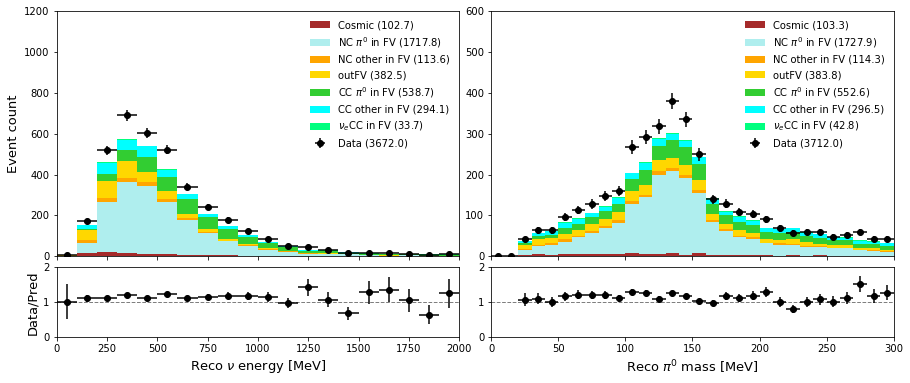

DATA/Prediction (left): 1.154
DATA/Prediction (right): 1.152


In [12]:
hist_energy = [x[x.kine_reco_Enu < 2000].kine_reco_Enu for x in samples]
w_ = [x[x.kine_reco_Enu < 2000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

hist_pi0mass = [x[x.kine_pio_mass < 300].kine_pio_mass for x in samples]
w__ = [x[x.kine_pio_mass < 300].weight for x in samples]
l__ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w__)]

two_panel_plot([hist_energy,hist_pi0mass], [w_,w__], [20,30], [(0,2000),(0,300)], [(0,1200),(0,600)], [colors,colors], [l_,l__], 
               [r'Reco $\nu$ energy [MeV]',r'Reco $\pi^{0}$ mass [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print('DATA/Prediction (left): %1.3f'%(sum(w_[0]) / sum([sum(x) for x in w_[1:]])))
print('DATA/Prediction (right): %1.3f'%(sum(w__[0]) / sum([sum(x) for x in w__[1:]])))

Panel Left: Chi-square = 81.5077, p-value = 0.0000
Panel Right: Chi-square = 90.3299, p-value = 0.0000


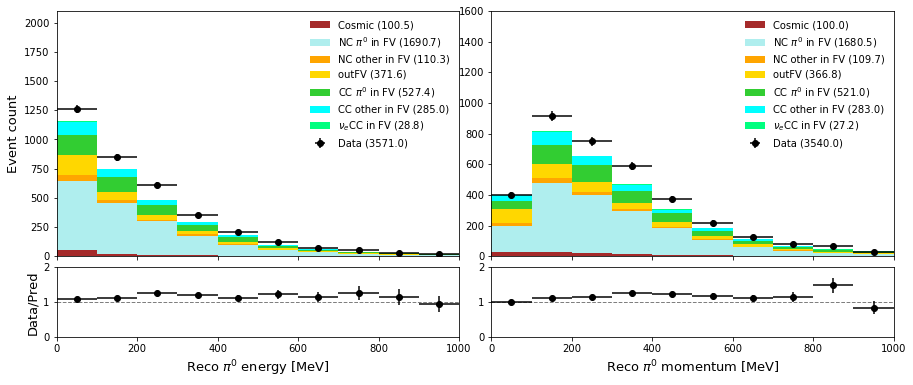

DATA/Prediction (left): 1.147
DATA/Prediction (right): 1.146


In [13]:
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

hist_pi0momentum = [x[x.reco_pi0_momentum < 1000].reco_pi0_momentum for x in samples]
w__ = [x[x.reco_pi0_momentum < 1000].weight for x in samples]
l__ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w__)]

two_panel_plot([hist_pi0energy,hist_pi0momentum], [w_,w__], [10,10], [(0,1000),(0,1000)], [(0,2100),(0,1600)], [colors,colors], [l_,l__], 
               [r'Reco $\pi^{0}$ energy [MeV]',r'Reco $\pi^{0}$ momentum [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print('DATA/Prediction (left): %1.3f'%(sum(w_[0]) / sum([sum(x) for x in w_[1:]])))
print('DATA/Prediction (right): %1.3f'%(sum(w__[0]) / sum([sum(x) for x in w__[1:]])))

In [14]:
num = sum(is_pi0(is_NC(is_generic(df_NC_pi0)), family='MC').weight)
den = sum(Active(df_NC_pi0_all).weight)
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(num, den, num/den))

w = [x.weight for x in samples]    # Doesn't depend on range of plots
signal = sum(w[2])
tot = sum([sum(x) for x in w[1:]]) # Excluding data
print('Total purity: %1.3f / %1.3f = %1.3f'%(signal, tot, signal/tot))

Total efficiency: 1727.901 / 6914.960 = 0.250
Total purity: 1727.901 / 3221.174 = 0.536


### Import weights new BDT

In [15]:
model = xgb.Booster()
model.load_model("../bnb/nc_training/model_notune_6_30_2pm.txt")

### Assign BDT weights

In [16]:
variables = BDT_variables[:-2] + KINE_variables                  # Variables for training

In [17]:
df_dataVII.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_dataVII[variables]))
df_cosmic.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_cosmic[variables]))
df_NC_pi0.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_NC_pi0[variables]))
df_NC_.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_NC_[variables]))
df_outFV.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_outFV[variables]))
df_CC_pi0.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_CC_pi0[variables]))
df_CC_.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_CC_[variables]))
df_nue.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_nue[variables]))

df_NC_pi0_all.loc[:,'ncpi0_score'] = model.predict(xgb.DMatrix(df_NC_pi0_all[variables]))

/home/gs627/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/gs627/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [18]:
VALUE = 0.89

def NCpi0(df, bdt_value=VALUE):
    df_ = df[(df.ncpi0_score > bdt_value) & (df.numu_score <= 0.9) & (df.nue_score <= 7)]
    return df_

def not_NCpi0(df, bdt_value=VALUE):
    df_ = df[~((df.ncpi0_score > bdt_value) & (df.numu_score <= 0.9) & (df.nue_score <= 7))]
    return df_

In [19]:
colors =   ['black',     'brown',    'paleturquoise',       'orange',          'gold',     'limegreen',            'aqua',            'springgreen']
labels =   ['Data',      'Cosmic',   r'NC $\pi^{0}$ in FV', 'NC other in FV',  'outFV',    r'CC $\pi^{0}$ in FV',  'CC other in FV',  r'$\nu_{e}$CC in FV']
families = ['DATA',      'MC',       'MC',                  'MC',              'MC',       'MC',                   'MC',              'MC']
samples =  [df_dataVII,  df_cosmic,  df_NC_pi0,             df_NC_,            df_outFV,   df_CC_pi0,              df_CC_,            df_nue]
samples =  [NCpi0(is_generic(x)) for x in samples]

# -------------------------------------------------------------------------

num = sum(NCpi0(is_generic(df_NC_pi0)).weight)
den = sum(Active(df_NC_pi0_all).weight)
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(num, den, num/den))

w = [x.weight for x in samples]    # Doesn't depend on range of plots
signal = sum(w[2])                 # df_NC_pi0
tot = sum([sum(x) for x in w[1:]]) # Excluding data
print('Total purity: %1.3f / %1.3f = %1.3f'%(signal, tot, signal/tot))

Total efficiency: 2267.277 / 6914.960 = 0.328
Total purity: 2267.277 / 3898.765 = 0.582


Chi-square = 112.2032, p-value = 0.0000


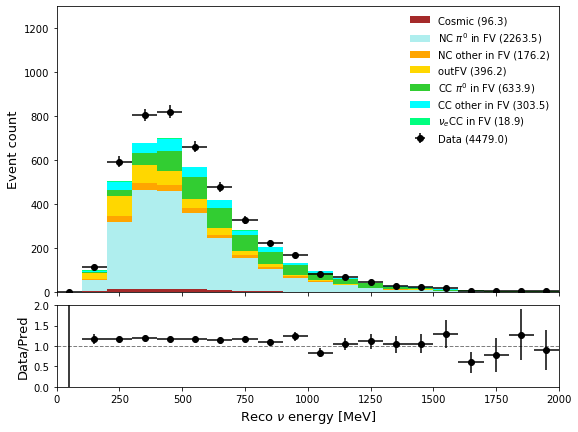

Data/Prediction: 4479.000 / 3888.625 = 1.152


In [20]:
hist_energy = [x[x.kine_reco_Enu < 2000].kine_reco_Enu for x in samples]
w_ = [x[x.kine_reco_Enu < 2000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]
one_panel_plot(hist_energy, w_, 20, (0,2000), (0,1300), colors, l_, r'Reco $\nu$ energy [MeV]', 'Event count',
               save_name='plot_fake_datasetVII/kine_reco_Enu.png')

sum_data = sum(w_[0])
sum_pred = sum([sum(x) for x in w_[1:]])
print('Data/Prediction: %1.3f / %1.3f = %1.3f'%(sum_data, sum_pred, sum_data/sum_pred))

Chi-square = 104.5398, p-value = 0.0000


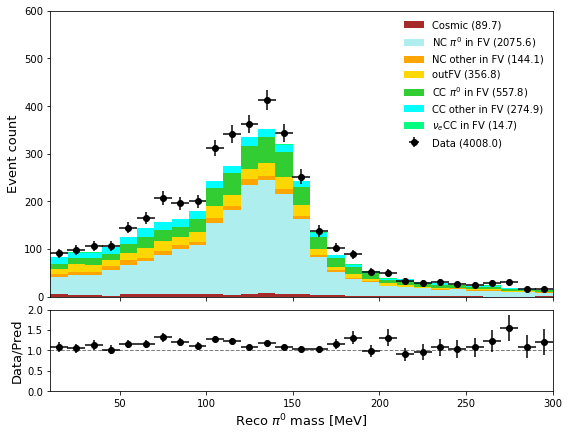

Data/Prediction: 4008.000 / 3513.675 = 1.141


In [21]:
hist_pi0mass = [x[(x.kine_pio_mass < 300) & (x.kine_pio_mass > 10)].kine_pio_mass for x in samples]
w_ = [x[(x.kine_pio_mass < 300) & (x.kine_pio_mass > 10)].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]
one_panel_plot(hist_pi0mass, w_, 29, (10,300), (0,600), colors, l_, r'Reco $\pi^{0}$ mass [MeV]', 'Event count',
               save_name='plot_fake_datasetVII/kine_pi0_mass.png')

sum_data = sum(w_[0])
sum_pred = sum([sum(x) for x in w_[1:]])
print('Data/Prediction: %1.3f / %1.3f = %1.3f'%(sum_data, sum_pred, sum_data/sum_pred))

Chi-square = 71.5331, p-value = 0.0000


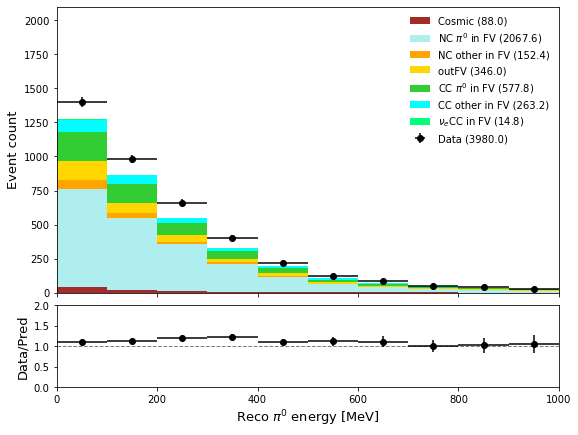

Data/Prediction: 3980.000 / 3509.805 = 1.134


In [22]:
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]
one_panel_plot(hist_pi0energy, w_, 10, (0,1000), (0,2100), colors, l_, r'Reco $\pi^{0}$ energy [MeV]', 'Event count',
               save_name='plot_fake_datasetVII/kine_pi0_energy.png')

sum_data = sum(w_[0])
sum_pred = sum([sum(x) for x in w_[1:]])
print('Data/Prediction: %1.3f / %1.3f = %1.3f'%(sum_data, sum_pred, sum_data/sum_pred))

Chi-square = 78.3184, p-value = 0.0000


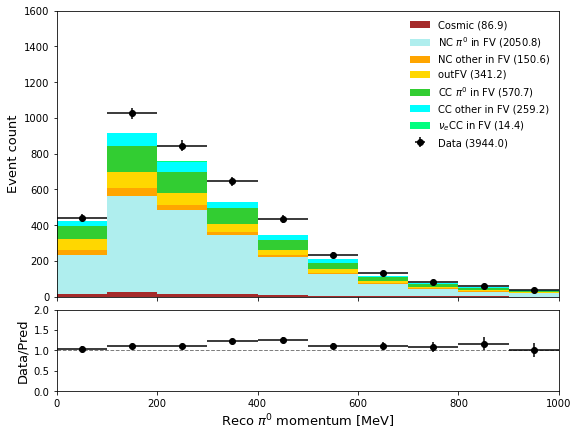

Data/Prediction: 3944.000 / 3473.884 = 1.135


In [23]:
hist_pi0momentum = [x[x.reco_pi0_momentum < 1000].reco_pi0_momentum for x in samples]
w_ = [x[x.reco_pi0_momentum < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]
one_panel_plot(hist_pi0momentum, w_, 10, (0,1000), (0,1600), colors, l_, r'Reco $\pi^{0}$ momentum [MeV]', 'Event count',
               save_name='plot_fake_datasetVII/kine_pi0_momentum.png')

sum_data = sum(w_[0])
sum_pred = sum([sum(x) for x in w_[1:]])
print('Data/Prediction: %1.3f / %1.3f = %1.3f'%(sum_data, sum_pred, sum_data/sum_pred))

In [24]:
num = sum(NCpi0(is_generic(df_NC_pi0)).weight)
den = sum(Active(df_NC_pi0_all).weight)
print('Total efficiency: %1.3f / %1.3f = %1.3f'%(num, den, num/den))

w = [x.weight for x in samples]    # Doesn't depend on range of plots
signal = sum(w[2])
tot = sum([sum(x) for x in w[1:]]) # Excluding data
print('Total purity: %1.3f / %1.3f = %1.3f'%(signal, tot, signal/tot))

Total efficiency: 2267.277 / 6914.960 = 0.328
Total purity: 2267.277 / 3898.765 = 0.582


### two_plot panels

In [ ]:
hist_energy = [x[x.kine_reco_Enu < 2000].kine_reco_Enu for x in samples]
w_ = [x[x.kine_reco_Enu < 2000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

hist_pi0mass = [x[(x.kine_pio_mass < 300) & (x.kine_pio_mass > 10)].kine_pio_mass for x in samples]
w__ = [x[(x.kine_pio_mass < 300) & (x.kine_pio_mass > 10)].weight for x in samples]
l__ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w__)]

two_panel_plot([hist_energy,hist_pi0mass], [w_,w__], [20,29], [(0,2000),(10,300)], [(0,1300),(0,600)], [colors,colors], [l_,l__], 
               [r'Reco $\nu$ energy [MeV]',r'Reco $\pi^{0}$ mass [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print('DATA/Prediction (left): %1.3f'%(sum(w_[0]) / sum([sum(x) for x in w_[1:]])))
print('DATA/Prediction (right): %1.3f'%(sum(w__[0]) / sum([sum(x) for x in w__[1:]])))

In [ ]:
hist_pi0energy = [x[x.reco_pi0_energy < 1000].reco_pi0_energy for x in samples]
w_ = [x[x.reco_pi0_energy < 1000].weight for x in samples]
l_ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w_)]

hist_pi0momentum = [x[x.reco_pi0_momentum < 1000].reco_pi0_momentum for x in samples]
w__ = [x[x.reco_pi0_momentum < 1000].weight for x in samples]
l__ = [x+' (%1.1f)'%(sum(y)) for x,y in zip(labels,w__)]

two_panel_plot([hist_pi0energy,hist_pi0momentum], [w_,w__], [10,10], [(0,1000),(0,1000)], [(0,2100),(0,1600)], [colors,colors], [l_,l__], 
               [r'Reco $\pi^{0}$ energy [MeV]',r'Reco $\pi^{0}$ momentum [MeV]'], ['Event count','Event count'])

# Evaluate DATA/Prediction
print('DATA/Prediction (left): %1.3f'%(sum(w_[0]) / sum([sum(x) for x in w_[1:]])))
print('DATA/Prediction (right): %1.3f'%(sum(w__[0]) / sum([sum(x) for x in w__[1:]])))